In [1]:
from common import GENRES
import keras
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Input, Dense, Lambda, Dropout, Activation, \
        TimeDistributed, Convolution1D, MaxPooling1D, BatchNormalization
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from optparse import OptionParser
from sys import stderr, argv
import os

import sys; sys.argv=['']; del sys

from keras import layers

SEED = 42
N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 256
BATCH_SIZE = 32
EPOCH_COUNT = 100




Using TensorFlow backend.


1000
splitted 700,300
(700, 647, 128)


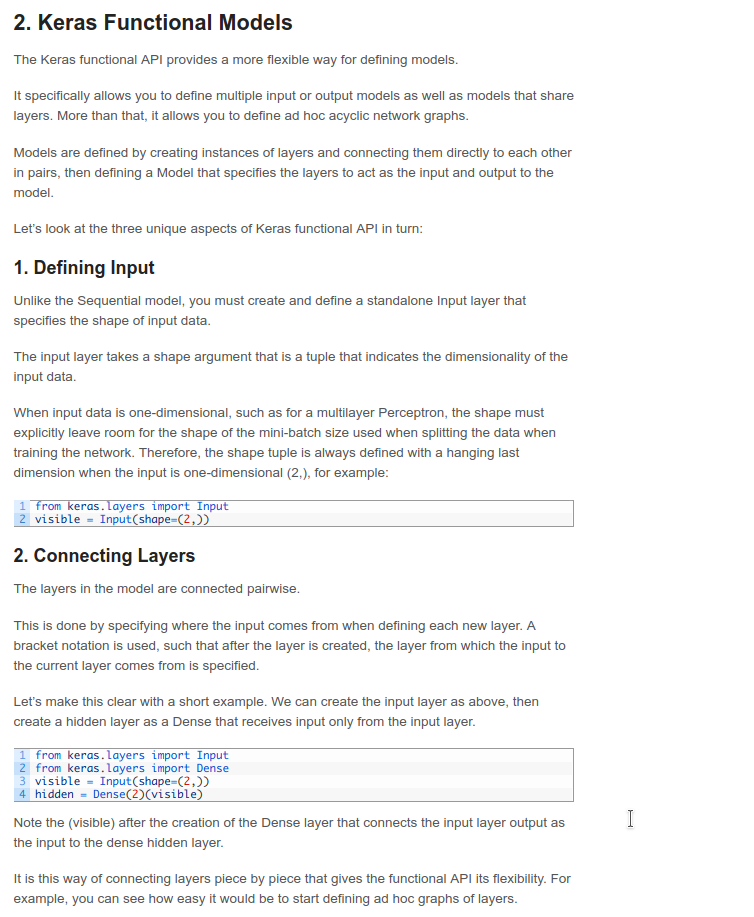

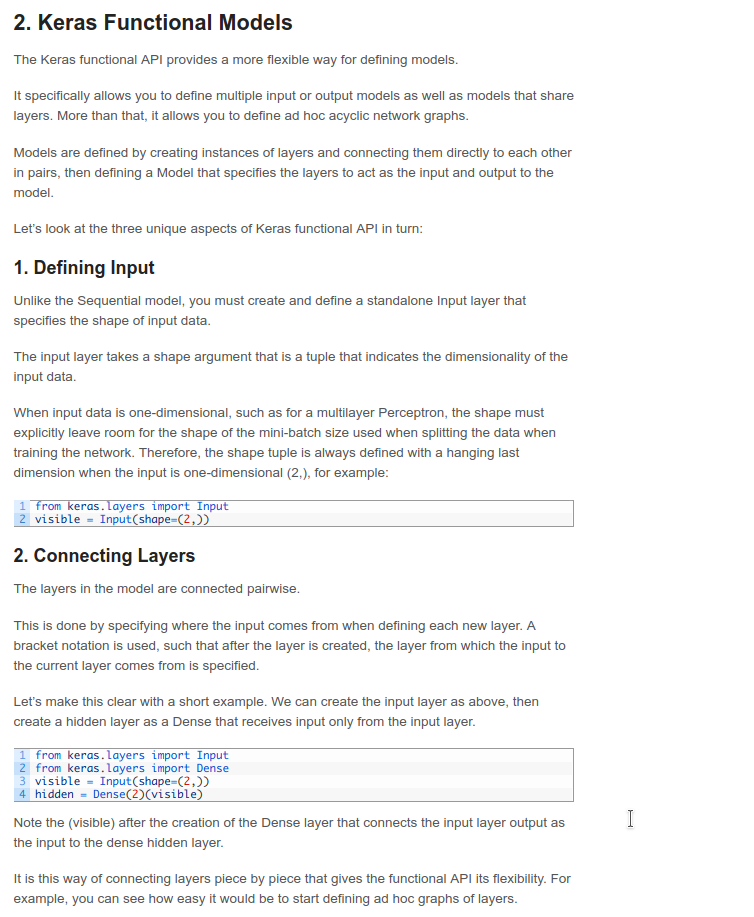

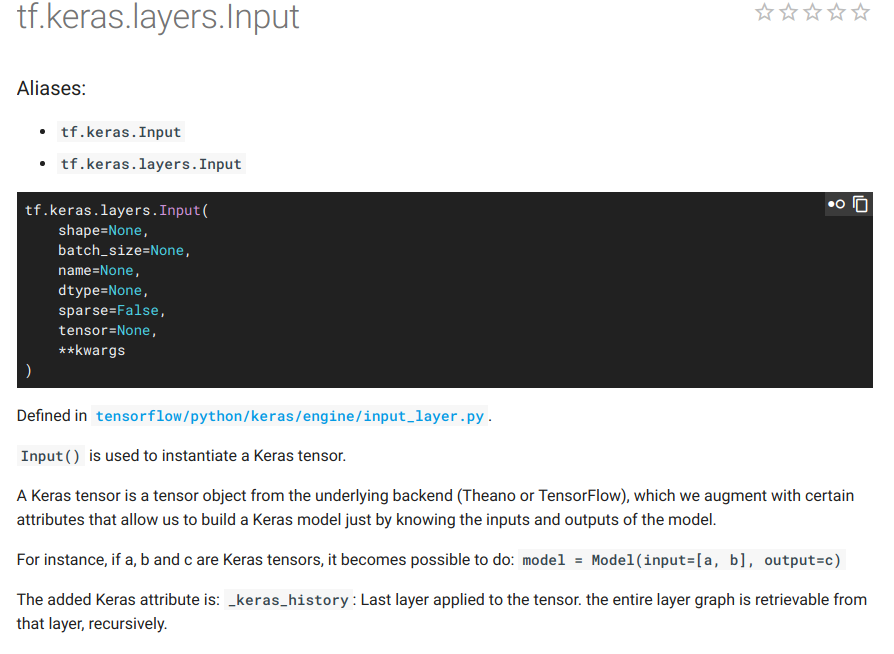

In [2]:
from keras.callbacks import TensorBoard
import os
path="./"

tensorboard_path=os.path.join(path,"tensorboard")
os.makedirs(tensorboard_path, exist_ok=True)
tb = TensorBoard(log_dir=tensorboard_path)

In [3]:
def train_model(data, model_path):
    x = data['x']
    y = data['y']
    (x_train, x_val, y_train, y_val) = train_test_split(x, y, test_size=0.3,
            random_state=SEED)

    print('Building model...')

    n_features = x_train.shape[2]
    
    print(x_train.shape)
    
    input_shape = (None, n_features)
    
    print(input_shape)
    
    model_input = Input(input_shape, name='input')
    layer = model_input
    for i in range(N_LAYERS):
        # second convolutional layer names are used by extract_filters.py
        layer = Convolution1D(
                filters=CONV_FILTER_COUNT,
                kernel_size=FILTER_LENGTH,
                name='convolution_' + str(i + 1)
            )(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(0.5)(layer)
    
    print(keras.backend.shape(layer))
    
    layer = TimeDistributed(Dense(len(GENRES)))(layer) 
    
    time_distributed_merge_layer = Lambda(
            function=lambda x: K.mean(x, axis=1), 
            output_shape=lambda shape: (shape[0],) + shape[2:],
            name='output_merged'
        )
    layer = time_distributed_merge_layer(layer)
    
    print(keras.backend.shape(layer))
    
    layer = Activation('softmax', name='output_realtime')(layer)
    model_output = layer
    model = Model(model_input, model_output)
    opt = Adam(lr=0.001)
    model.summary()
    
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )

    print('Training...')
    model.fit(
        x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
        validation_data=(x_val, y_val), verbose=1, callbacks=[
            ModelCheckpoint(
                model_path, save_best_only=True, monitor='val_acc', verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            ),
            tb
        ]
    )

    return model


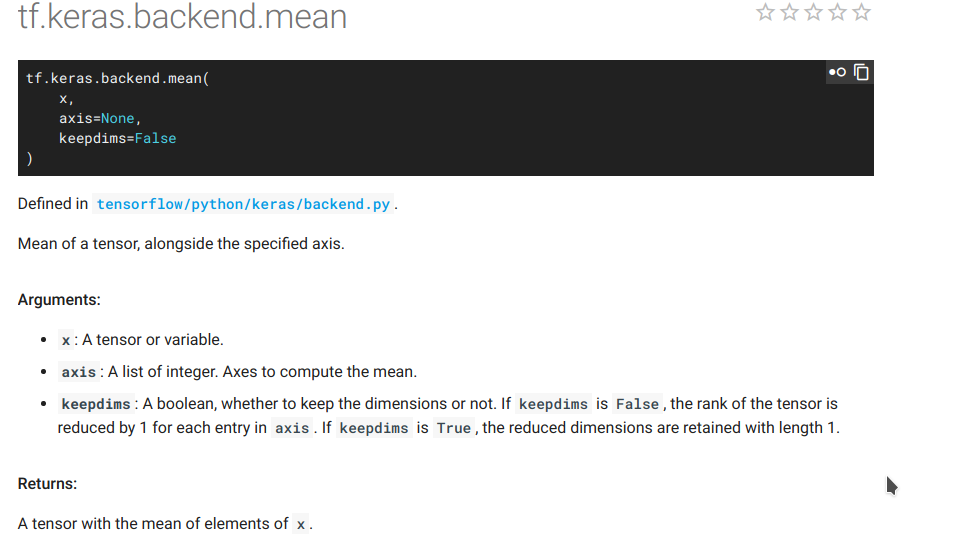

In [4]:
if __name__ == '__main__':
    parser = OptionParser()
    parser.add_option('-d', '--data_path', dest='data_path',
            #default=os.path.join(os.path.dirname(__file__),'data/data.pkl'),
            default=os.path.join(os.getcwd(), 'data/data.pkl'),
            help='path to the data pickle', metavar='DATA_PATH')
    parser.add_option('-m', '--model_path', dest='model_path',
            default=os.path.join(os.getcwd(),
                'models/model.h5'),
            help='path to the output model HDF5 file', metavar='MODEL_PATH')
    options, args = parser.parse_args()

    with open(options.data_path, 'rb') as f:
        data = pickle.load(f)
    
    
    train_model(data, options.model_path)
    


Building model...
(700, 647, 128)
(None, 128)
Tensor("Shape:0", shape=(3,), dtype=int32)
Tensor("Shape_1:0", shape=(2,), dtype=int32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 128)         0         
_________________________________________________________________
convolution_1 (Conv1D)       (None, None, 256)         164096    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 256)         1024      
_________________________________________________________________
activation_1 (Activation)    (None, None, 256)         0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 256)         0         
________

700/700 [==============================] - 16s 22ms/step - loss: 0.2931 - acc: 0.9086 - val_loss: 1.1264 - val_acc: 0.6567

Epoch 00025: val_acc did not improve from 0.69000
Epoch 26/100
700/700 [==============================] - 16s 22ms/step - loss: 0.2538 - acc: 0.9243 - val_loss: 0.9501 - val_acc: 0.6767

Epoch 00026: val_acc did not improve from 0.69000
Epoch 27/100
700/700 [==============================] - 16s 22ms/step - loss: 0.2729 - acc: 0.8943 - val_loss: 1.1870 - val_acc: 0.6233

Epoch 00027: val_acc did not improve from 0.69000
Epoch 28/100
700/700 [==============================] - 17s 25ms/step - loss: 0.2656 - acc: 0.9157 - val_loss: 1.5261 - val_acc: 0.5800

Epoch 00028: val_acc did not improve from 0.69000
Epoch 29/100
700/700 [==============================] - 16s 23ms/step - loss: 0.2305 - acc: 0.9286 - val_loss: 1.6070 - val_acc: 0.5533

Epoch 00029: val_acc did not improve from 0.69000
Epoch 30/100
700/700 [==============================] - 15s 21ms/step - loss: 


Epoch 00064: val_acc did not improve from 0.79667
Epoch 65/100
700/700 [==============================] - 17s 24ms/step - loss: 0.0310 - acc: 0.9971 - val_loss: 0.8255 - val_acc: 0.7600

Epoch 00065: val_acc did not improve from 0.79667

Epoch 00065: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 66/100
700/700 [==============================] - 17s 25ms/step - loss: 0.0326 - acc: 0.9957 - val_loss: 0.7509 - val_acc: 0.7667

Epoch 00066: val_acc did not improve from 0.79667
Epoch 67/100
700/700 [==============================] - 17s 25ms/step - loss: 0.0276 - acc: 1.0000 - val_loss: 0.7397 - val_acc: 0.7733

Epoch 00067: val_acc did not improve from 0.79667
Epoch 68/100
700/700 [==============================] - 17s 24ms/step - loss: 0.0253 - acc: 0.9986 - val_loss: 0.7469 - val_acc: 0.7700

Epoch 00068: val_acc did not improve from 0.79667
Epoch 69/100
700/700 [==============================] - 17s 25ms/step - loss: 0.0267 - acc: 0.9986 - val_loss: 0.7353 - 

In [ ]:
import tensorflow as tf
from tensorflow.python import debug as tf_debug
import keras

keras.backend.set_session(
    tf_debug.TensorBoardDebugWrapperSession(tf.Session(), "infinity-Inspiron-15-7000-Gaming:6007"))